In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pyodbc
import pandas as pd  # sure takes a long time

import numpy as np
import umap
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.colors import ListedColormap
import seaborn as sns

import sklearn
from sklearn.preprocessing import StandardScaler
from collections import defaultdict

import dizzy_util as util
import eval_util
import pseudo_label
import cluster_umap

In [3]:
pos_dataset = util.extractDataset("B00_ML4TrgPos_", {"Note", "WithRole", "AllMed", "Vital", "HF", "DispensedDrug"})

,TABLE_CATALOG,TABLE_SCHEMA,TABLE_NAME,TABLE_TYPE
0,ORD_Singh_201911038D,Dflt,_B00_ML4TrgPos_Y201621_01_04_cohort,BASE TABLE
1,ORD_Singh_201911038D,Dflt,_B00_ML4TrgPos_Y201621_01_04_Demorgraphics,BASE TABLE
2,ORD_Singh_201911038D,Dflt,_B00_ML4TrgPos_Y201621_04_04_Lab,BASE TABLE
3,ORD_Singh_201911038D,Dflt,_B00_ML4TrgPos_Y201621_05_04_Rad,BASE TABLE
4,ORD_Singh_201911038D,Dflt,_B00_ML4TrgPos_Y201621_06_Med_04_RxOutpat,BASE TABLE
5,ORD_Singh_201911038D,Dflt,_B00_ML4TrgPos_Y201621_06_Med_05_BCMA_Dispense...,BASE TABLE
6,ORD_Singh_201911038D,Dflt,_B00_ML4TrgPos_Y201621_06_Med_07_NonVAMed,BASE TABLE
7,ORD_Singh_201911038D,Dflt,_B00_ML4TrgPos_Y201621_06_Med_08_AllMed,BASE TABLE
8,ORD_Singh_201911038D,Dflt,_B00_ML4TrgPos_Y201621_08_Consult,BASE TABLE
9,ORD_Singh_201911038D,Dflt,_B00_ML4TrgPos_Y201621_12_ICD,BASE TABLE


dict_keys(['cohort', 'Demorgraphics', 'Lab', 'Rad', 'RxOutpat', 'NonVAMed', 'Consult', 'ICD'])


In [4]:
dizziness_df, label_map = util.retrieveLabels()
dizziness_df["DxErrorERCoded"].value_counts()
label_df = util.convertLabelMap(label_map)
pos_datasubset = util.extractAndStandarizeCohort(pos_dataset, "Dizziness")

In [5]:
nomod_mod_label_df = label_df[(label_df.Label == "NoMOD") | (label_df.Label == "MOD")].copy()
nomod_mod_label_df.reset_index(inplace=True, drop=True)

In [ ]:
nomod_mod_label_df

In [40]:
icd_df = pos_datasubset["ICD"]
cohort_df = pos_datasubset["cohort"]
outpat_df = pos_datasubset["RxOutpat"]
rad_df = pos_datasubset["Rad"]
demo_df = pos_datasubset["Demorgraphics"]
consult_df = pos_datasubset["Consult"]

In [8]:
edstart = util.extractFirstVisitIndexDatetime(pos_datasubset["cohort"])

# Feature Extraction

In [9]:
# extract patient age
age_feature = util.makeAgeFeature(demo_df)

In [10]:
# extract patient ER visit time features
index_feature = util.makeIndexFeature(cohort_df)

In [11]:
# fiter ICDs to only look at those before ER index visit
filtered_icd_df = util.filterDFByTimes(icd_df, util.ICD_PATIENT_ID, "DiagDateTime", edstart)

In [ ]:
# extract presence of important risk factor ICDs and count
icd_vec = util.makeNewICDVec(filtered_icd_df)
display(icd_vec)
icd_feature = util.Feature(icd_vec, "PatientSSN")

In [ ]:
# extract whether patient got a stroke diagnosis at ED visit
icd_diag_df = util.findERDiagnosis(icd_df, cohort_df)
display(icd_diag_df)
icd_codes = util.getICDCodes()
print(icd_codes.keys())
stroke_diags = util.filterDFByCodeSet(icd_diag_df, "ICD", icd_codes['Hx of stroke or TIA'])
icd_diag_vec = pd.DataFrame({"PatientSSN":stroke_diags.PatientSSN.unique()})
icd_diag_vec["HasStrokeDiag"] = 1
display(icd_diag_vec)
icd_diag_feature = util.Feature(icd_diag_vec, "PatientSSN")

In [14]:
# extract whether patient got a neurology consult
consult_feature = util.makeConsultFeature(pos_datasubset["Consult"], cohort_df, edstart)

In [15]:
# extract whether patient got a CT or MRI
rad_feature = util.makeRadFeature(pos_datasubset["Rad"], cohort_df, edstart)

In [16]:
feature_vec = util.mergeFeatures([consult_feature, rad_feature, age_feature, index_feature, icd_diag_feature, icd_feature])

In [24]:
# filter out PMOD and CodingErrors from vectors
labeled_mnm_feature_vec = feature_vec.merge(label_df, how="outer")
labeled_mnm_feature_vec = labeled_mnm_feature_vec.fillna("Unknown")
labeled_mnm_feature_vec = labeled_mnm_feature_vec[(labeled_mnm_feature_vec.Label != "PMOD") & (labeled_mnm_feature_vec.Label != "CodingEr")].copy()
labeled_mnm_feature_vec.reset_index(inplace=True, drop=True)
mnm_feature_vec = labeled_mnm_feature_vec.drop(["Label"], axis=1, inplace=False)

In [ ]:
mnm_feature_vec

### UMAP to test features

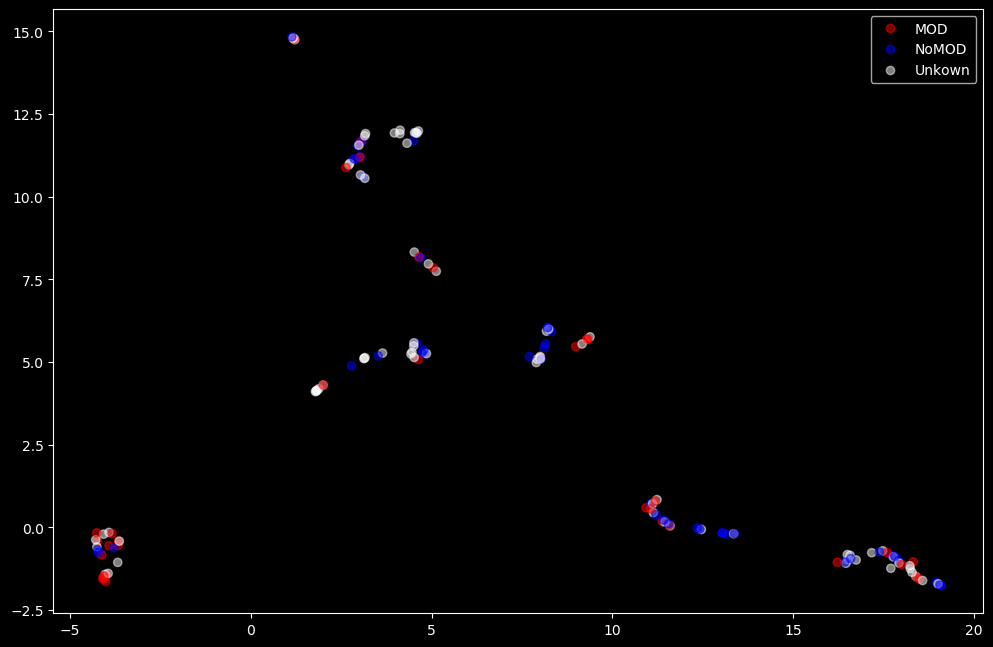

In [22]:
reducer = umap.UMAP(metric="correlation", min_dist=0, n_neighbors=5)
embedding = util.UMAPPlot(reducer, mnm_feature_vec, label_map)

In [ ]:
cluster_umap.run_clustering_on_umap(embedding, 7, mnm_feature_vec, nomod_mod_label_df)

In [ ]:
util.UMAPClosestPairs(labeled_mnm_feature_vec, embedding)

In [ ]:
temp = consult_df[consult_df.PatientSSN == 999]
util.filterDFByCodeSet(temp, "ConStopCode", util.NEURO_CONSULT_CODES)

In [ ]:
temp = rad_df[rad_df.PatientSSN == 999]
util.filterDFByCodeSet(temp, "CPTCode", util.CT_CPT_CODES)

In [ ]:
cohort_df[cohort_df.patientSSN == 999]

In [ ]:

temp = consult_df[consult_df.PatientSSN == 999]
util.filterDFByCodeSet(temp, "ConStopCode", util.NEURO_CONSULT_CODES)

In [ ]:
cohort_df[cohort_df.patientSSN == 999]

In [51]:
new_consult_vec = util.makeNewConsultVec2(consult_df, cohort_df, edstart)
new_rad_vec = util.makeNewRadVec2(rad_df, cohort_df, edstart)

In [53]:
consult_vec = consult_feature.norm_vec
rad_vec = rad_feature.norm_vec

In [ ]:
new_consult_vec["diff"] = new_consult_vec.HasConsult - consult_vec.HasConsult
display(new_consult_vec[new_consult_vec["diff"] != 0])

In [ ]:
new_consult_vec[new_consult_vec["diff"] != 0].merge(cohort_df, how="inner", left_on="PatientSSN", right_on="patientSSN")

In [ ]:
new_rad_vec["CT_diff"] = new_rad_vec.HasCT - rad_vec.HasCT
new_rad_vec["MRI_diff"] = new_rad_vec.HasMRI - rad_vec.HasMRI
display(new_rad_vec[new_rad_vec["CT_diff"] != 0])
display(new_rad_vec[new_rad_vec["MRI_diff"] != 0])

In [65]:
new_rad_feature = util.Feature(util.makeNewRadVec2(rad_df, cohort_df, edstart))
new_consult_feature = util.Feature(util.makeNewConsultVec2(consult_df, cohort_df, edstart))

In [66]:
feature_vec2 = util.mergeFeatures([new_consult_feature, new_rad_feature, age_feature, index_feature, icd_diag_feature, icd_feature])
feature_vec2 = feature_vec2.merge(label_df, how="outer")
feature_vec2 = feature_vec2.fillna("Unknown")
feature_vec2 = feature_vec2[(feature_vec2.Label != "PMOD") & (feature_vec2.Label != "CodingEr")].copy()
feature_vec2.reset_index(inplace=True, drop=True)
u_feature_vec2 = feature_vec2.drop(["Label"], axis=1, inplace=False)

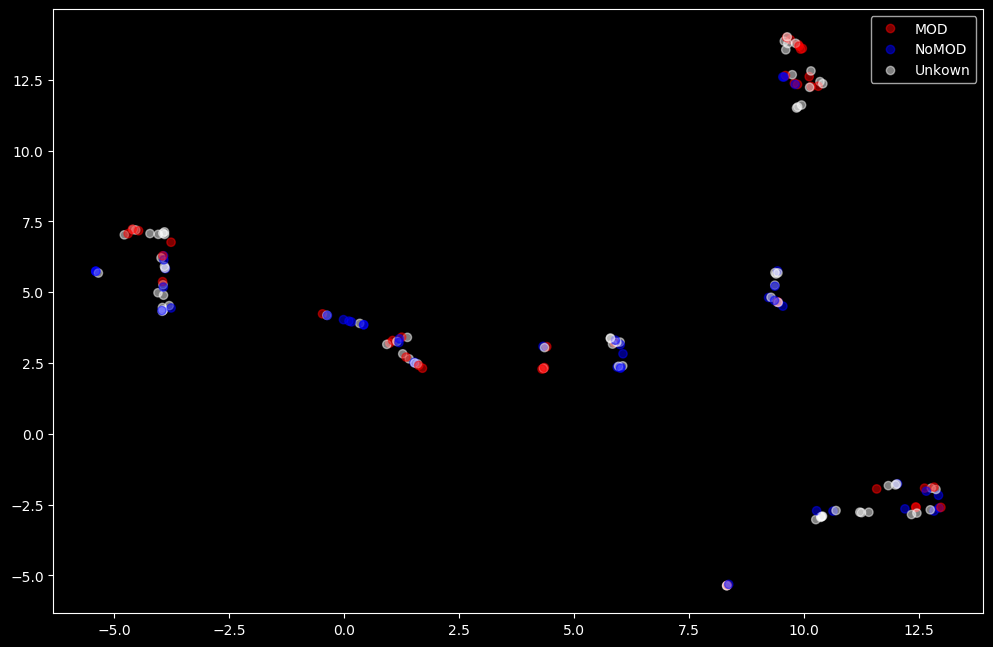

In [67]:
reducer2 = umap.UMAP(metric="correlation", min_dist=0, n_neighbors=5)
embedding2 = util.UMAPPlot(reducer2, u_feature_vec2, label_map)

In [ ]:
cluster_umap.run_clustering_on_umap(embedding2, 7, u_feature_vec2, nomod_mod_label_df)

In [ ]:
cluster_umap.run_clustering_on_umap(embedding2, 11, u_feature_vec2, nomod_mod_label_df)

# Train Test Split

In [73]:
# machine learning
from sklearn import preprocessing
from sklearn import utils
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder, KBinsDiscretizer
from sklearn.feature_selection import VarianceThreshold, SelectKBest, RFECV, chi2, mutual_info_classif

In [74]:
# seed
RANDOM_STATE_SEED = 42
# train-test-split test size
TEST_SIZE = 0.15
# logistic regression model constants
LOGISTIC_REGRESSION_ITER = 10000

In [32]:
labeled_df, unlabeled_df, X_cols, y_col = util.makeDataset(mnm_feature_vec, nomod_mod_label_df)
X_train, X_test, y_train, y_test = train_test_split(labeled_df[X_cols], labeled_df[y_col], test_size=TEST_SIZE, random_state=RANDOM_STATE_SEED)

# Pseudo Labeling

In [82]:
# create pseudo labeler based on the number of clusters previously estimated
pseudo_labeler = cluster_umap.UMAPLabeler(reducer, 7)

In [36]:
# Pseudo label the train set and unlabeled set. (Don't pass in SSNs)
pX, py, pw = pseudo_label.pseudo_label_dataset(pseudo_labeler, X_train, y_train, unlabeled_df[X_cols])

,HasConsult,HasCT,HasMRI,Age,ed_duration,ed_inp_delta,HasStrokeDiag,Hx of stroke or TIA,Hx aneurysm,Atrial fibrillation,RiskFactorCount
0,0.0,0.0,0.0,0.926829,0.072531,0.113519,0.0,0.0,0.0,0.0,0.571429
1,0.0,0.0,0.0,0.536585,0.495238,0.436485,0.0,0.0,0.0,0.0,0.428571
2,1.0,1.0,0.0,0.512195,0.631240,0.229592,0.0,0.0,0.0,0.0,0.642857
3,0.0,1.0,0.0,0.560976,0.332886,0.477707,0.0,0.5,0.0,0.0,0.714286
4,0.0,1.0,0.0,0.975610,0.230683,0.036921,0.0,1.0,0.5,1.0,0.642857
...,...,...,...,...,...,...,...,...,...,...,...
142,0.0,1.0,0.0,0.926829,0.490720,0.028025,1.0,0.0,0.0,0.0,0.142857
143,0.0,1.0,1.0,0.902439,0.155441,0.046192,0.0,0.0,0.0,0.0,0.285714
144,0.0,1.0,0.0,0.634146,0.293494,0.170609,0.0,0.5,0.0,0.0,0.642857
145,0.0,1.0,0.0,0.878049,0.131337,0.039496,0.0,1.0,1.0,1.0,0.857143


array([[0.35714286, 0.64285714],
       [0.28571429, 0.71428571],
       [0.33333333, 0.66666667],
       [0.5       , 0.5       ],
       [0.76923077, 0.23076923],
       [0.38461538, 0.61538462],
       [0.6       , 0.4       ]])

(69,)
0 1.0
1 0.0


# Logistic Regression

C:\Users\VHAHOUYuM\AppData\Local\Continuum\anaconda3\envs\ahrq-tf\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Best penalty: l2
Best C: 0.2782559402207126
Best solver: liblinear
[[6 1]
 [3 3]]
              precision    recall  f1-score   support

         0.0       0.67      0.86      0.75         7
         1.0       0.75      0.50      0.60         6

    accuracy                           0.69        13
   macro avg       0.71      0.68      0.68        13
weighted avg       0.71      0.69      0.68        13

[[36  1]
 [20 12]]
              precision    recall  f1-score   support

         0.0       0.64      0.97      0.77        37
         1.0       0.92      0.38      0.53        32

    accuracy                           0.70        69
   macro avg       0.78      0.67      0.65        69
weighted avg       0.77      0.70      0.66        69



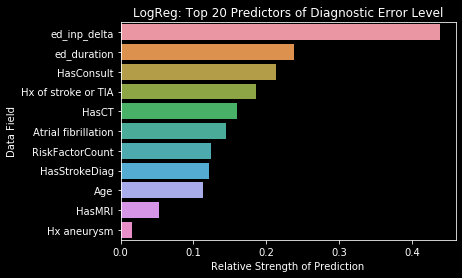

In [42]:
#
hyperparameter_grid_log = {
#     'penalty': ['none', 'l1', 'l2']
    'penalty': ['l1', 'l2']
    ,'C': np.logspace(-5, 5, 10)
    ,'solver': ['liblinear','saga']
#     ,'multi_class': ['ovr']
#     ,'fit_intercept': [True, False]
}

best_model_log = eval_util.runLogRegWithDataset(hyperparameter_grid_log, X_cols, X_train, X_test, y_train, y_test)

Best penalty: l1
Best C: 0.1
Best solver: liblinear
[[7 0]
 [6 0]]
              precision    recall  f1-score   support

         0.0       0.54      1.00      0.70         7
         1.0       0.00      0.00      0.00         6

    accuracy                           0.54        13
   macro avg       0.27      0.50      0.35        13
weighted avg       0.29      0.54      0.38        13

[[112   0]
 [112   0]]
              precision    recall  f1-score   support

         0.0       0.50      1.00      0.67       112
         1.0       0.00      0.00      0.00       112

    accuracy                           0.50       224
   macro avg       0.25      0.50      0.33       224
weighted avg       0.25      0.50      0.33       224



C:\Users\VHAHOUYuM\AppData\Local\Continuum\anaconda3\envs\ahrq-tf\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\VHAHOUYuM\AppData\Local\Continuum\anaconda3\envs\ahrq-tf\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


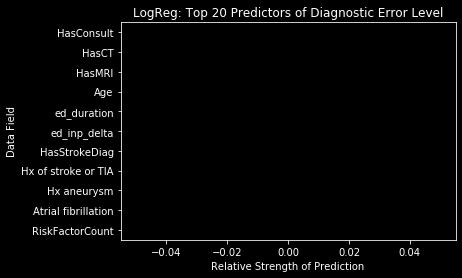

In [39]:
# run logistic regression on pseudo-labeled data
hyperparameter_grid_log = {
#     'penalty': ['none', 'l1', 'l2']
    'penalty': ['l1', 'l2']
    ,'C': np.logspace(-1, 10, 10)
    ,'solver': ['liblinear','saga']
#     ,'multi_class': ['ovr']
#     ,'fit_intercept': [True, False]
}

best_model_log = eval_util.runLogRegWithDataset(hyperparameter_grid_log, X_cols, pX, X_test, py, y_test, pw)

# Neural Net

In [75]:
import tensorflow as tf

In [248]:
nn_X_train = X_train.copy()

In [272]:
nn_X_train.shape

(69, 11)

In [249]:
len(nn_X_train.columns)

11

In [273]:
nn_model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(len(nn_X_train.columns),)),
#     tf.keras.layers.Dense(4, activation="relu"),
    tf.keras.layers.Dense(10, activation="relu"),
    tf.keras.layers.Dense(4, activation="relu"),
    tf.keras.layers.Dense(1, activation="sigmoid"),
])

In [274]:
nn_model.compile(optimizer="adam",
                loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
                metrics=['accuracy', tf.keras.metrics.AUC()])
#                 metrics=tf.metrics.BinaryAccuracy(threshold=0.0))

In [275]:
nn_model.summary()

Model: "sequential_39"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_111 (Dense)            (None, 10)                120       
_________________________________________________________________
dense_112 (Dense)            (None, 4)                 44        
_________________________________________________________________
dense_113 (Dense)            (None, 1)                 5         
Total params: 169
Trainable params: 169
Non-trainable params: 0
_________________________________________________________________


In [276]:
history = nn_model.fit(nn_X_train.to_numpy(), y_train.to_numpy(), epochs=200)

Train on 69 samples
Epoch 1/200
69/69 [==============================] - 2s 32ms/sample - loss: 0.7016 - accuracy: 0.4638 - auc_8: 0.5194
Epoch 2/200
69/69 [==============================] - 0s 5ms/sample - loss: 0.6989 - accuracy: 0.5362 - auc_8: 0.5186
Epoch 3/200
69/69 [==============================] - 1s 9ms/sample - loss: 0.6964 - accuracy: 0.5217 - auc_8: 0.5211
Epoch 4/200
69/69 [==============================] - 0s 7ms/sample - loss: 0.6947 - accuracy: 0.5217 - auc_8: 0.5342
Epoch 5/200
69/69 [==============================] - 1s 7ms/sample - loss: 0.6929 - accuracy: 0.5072 - auc_8: 0.5317
Epoch 6/200
69/69 [==============================] - 0s 5ms/sample - loss: 0.6912 - accuracy: 0.4928 - auc_8: 0.5418
Epoch 7/200
69/69 [==============================] - 0s 5ms/sample - loss: 0.6898 - accuracy: 0.4783 - auc_8: 0.5401
Epoch 8/200
69/69 [==============================] - 0s 3ms/sample - loss: 0.6890 - accuracy: 0.4638 - auc_8: 0.5418
Epoch 9/200
69/69 [========================

69/69 [==============================] - 0s 3ms/sample - loss: 0.5956 - accuracy: 0.7391 - auc_8: 0.8024
Epoch 140/200
69/69 [==============================] - 0s 4ms/sample - loss: 0.5948 - accuracy: 0.7391 - auc_8: 0.8036
Epoch 141/200
69/69 [==============================] - 0s 3ms/sample - loss: 0.5939 - accuracy: 0.7391 - auc_8: 0.7994
Epoch 142/200
69/69 [==============================] - 0s 2ms/sample - loss: 0.5935 - accuracy: 0.7391 - auc_8: 0.8011
Epoch 143/200
69/69 [==============================] - 0s 4ms/sample - loss: 0.5924 - accuracy: 0.7391 - auc_8: 0.7990
Epoch 144/200
69/69 [==============================] - 0s 4ms/sample - loss: 0.5916 - accuracy: 0.7391 - auc_8: 0.8015
Epoch 145/200
69/69 [==============================] - 0s 362us/sample - loss: 0.5909 - accuracy: 0.7391 - auc_8: 0.7998
Epoch 146/200
69/69 [==============================] - 0s 2ms/sample - loss: 0.5903 - accuracy: 0.7391 - auc_8: 0.7994
Epoch 147/200
69/69 [==============================] - 0s 4m

In [232]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'auc_2'])

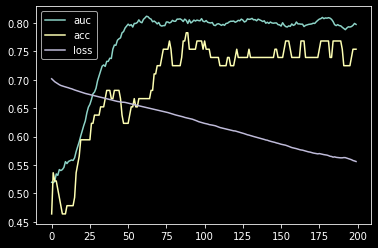

In [277]:
plt.plot(history.history['auc_8'])
plt.plot(history.history['accuracy'])
plt.plot(history.history['loss'])
plt.legend(['auc', 'acc', 'loss'], loc='upper left')
plt.show()

In [327]:
nn_X_test = X_test.copy()
predictions = nn_model.predict(nn_X_test.to_numpy())

In [329]:
(predictions > 0.5).astype(int)

array([[1],
       [1],
       [0],
       [0],
       [0],
       [1],
       [0],
       [0],
       [0],
       [1],
       [1],
       [0],
       [0]])

In [270]:
y_test

63     1.0
1      1.0
49     0.0
65     0.0
43     0.0
60     0.0
22     0.0
111    1.0
11     0.0
26     1.0
103    1.0
68     1.0
134    0.0
Name: Label, dtype: float64

In [280]:
nn_model.evaluate(nn_X_test.to_numpy(), y_test.to_numpy())

13/13 [==============================] - 1s 57ms/sample - loss: 0.4994 - accuracy: 0.7692 - auc_8: 0.9286


[0.4993654787540436, 0.7692308, 0.9285714]

In [330]:
print(sklearn.metrics.classification_report(y_test.to_numpy(), (predictions > 0.5).astype(int)))

              precision    recall  f1-score   support

         0.0       0.75      0.86      0.80         7
         1.0       0.80      0.67      0.73         6

    accuracy                           0.77        13
   macro avg       0.78      0.76      0.76        13
weighted avg       0.77      0.77      0.77        13



In [269]:
predictions

array([[0.4009604 ],
       [0.49317786],
       [0.366005  ],
       [0.29467878],
       [0.45234746],
       [0.39960438],
       [0.48585972],
       [0.52222246],
       [0.387032  ],
       [0.4661174 ],
       [0.40895733],
       [0.46646512],
       [0.17324086]], dtype=float32)

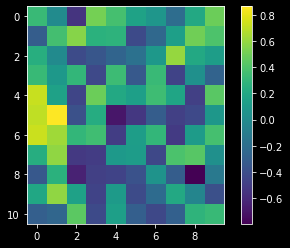

In [287]:
plt.imshow(nn_model.layers[0].get_weights()[0])
plt.colorbar()

In [286]:
nn_X_train

,HasConsult,HasCT,HasMRI,Age,ed_duration,ed_inp_delta,HasStrokeDiag,Hx of stroke or TIA,Hx aneurysm,Atrial fibrillation,RiskFactorCount
71,0.0,0.0,0.0,0.926829,0.072531,0.113519,0.0,0.0,0.0,0.0,0.571429
136,0.0,0.0,0.0,0.536585,0.495238,0.436485,0.0,0.0,0.0,0.0,0.428571
95,1.0,1.0,0.0,0.512195,0.631240,0.229592,0.0,0.0,0.0,0.0,0.642857
151,0.0,1.0,0.0,0.560976,0.332886,0.477707,0.0,0.5,0.0,0.0,0.714286
123,0.0,1.0,0.0,0.975610,0.230683,0.036921,0.0,1.0,0.5,1.0,0.642857
...,...,...,...,...,...,...,...,...,...,...,...
46,0.0,1.0,0.0,0.804878,0.430253,0.077941,0.0,0.0,0.0,0.0,0.428571
121,0.0,1.0,0.0,0.682927,0.449692,0.195533,0.0,0.0,0.0,0.0,0.428571
138,1.0,1.0,0.0,0.609756,0.465639,0.210485,0.0,1.0,1.0,0.0,0.428571
35,0.0,1.0,0.0,0.853659,0.447739,0.367584,0.0,0.0,0.0,0.0,0.428571


In [246]:
tf.keras.utils.plot_model(nn_model, show_shapes=True)

Failed to import pydot. You must install pydot and graphviz for `pydotprint` to work.


### NN + Pseudo Labeling

In [117]:
# sanity check: first half of py are 1s
py

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0.])

In [307]:
# add bias term, and only keep first half of pX pw
# this is because we only train with the probability of being label 1
n = int(pX.shape[0]/2)
nn_pX = pX.iloc[:n, :].copy()
nn_py = pw[:n]

In [308]:
nn_py = np.stack([1- nn_py, nn_py], -1)

In [309]:
nn_py

array([[0.        , 1.        ],
       [1.        , 0.        ],
       [1.        , 0.        ],
       [1.        , 0.        ],
       [1.        , 0.        ],
       [1.        , 0.        ],
       [1.        , 0.        ],
       [0.        , 1.        ],
       [0.        , 1.        ],
       [0.        , 1.        ],
       [0.        , 1.        ],
       [1.        , 0.        ],
       [1.        , 0.        ],
       [0.        , 1.        ],
       [0.        , 1.        ],
       [1.        , 0.        ],
       [0.        , 1.        ],
       [1.        , 0.        ],
       [1.        , 0.        ],
       [0.        , 1.        ],
       [1.        , 0.        ],
       [1.        , 0.        ],
       [1.        , 0.        ],
       [0.        , 1.        ],
       [0.        , 1.        ],
       [0.        , 1.        ],
       [1.        , 0.        ],
       [0.        , 1.        ],
       [1.        , 0.        ],
       [0.        , 1.        ],
       [1.

In [310]:
nn_pmodel = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(len(nn_pX.columns),)),
#     tf.keras.layers.Dense(4, activation="relu"),
    tf.keras.layers.Dense(10, activation="relu"),
    tf.keras.layers.Dense(4, activation="relu"),
    tf.keras.layers.Dense(2, activation="softmax"),
])

In [311]:
nn_pmodel.compile(optimizer="adam",
                loss=tf.keras.losses.KLDivergence(),
                metrics=["accuracy"])
#                 metrics=tf.metrics.BinaryAccuracy(threshold=0.0))

In [312]:
nn_pmodel.summary()

Model: "sequential_43"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_123 (Dense)            (None, 10)                120       
_________________________________________________________________
dense_124 (Dense)            (None, 4)                 44        
_________________________________________________________________
dense_125 (Dense)            (None, 2)                 10        
Total params: 174
Trainable params: 174
Non-trainable params: 0
_________________________________________________________________


In [313]:
history = nn_pmodel.fit(nn_pX.to_numpy(), nn_py, epochs=200)

Train on 112 samples
Epoch 1/200
112/112 [==============================] - 1s 13ms/sample - loss: 0.4905 - accuracy: 0.6429
Epoch 2/200
112/112 [==============================] - 1s 7ms/sample - loss: 0.4785 - accuracy: 0.6429
Epoch 3/200
112/112 [==============================] - 1s 5ms/sample - loss: 0.4702 - accuracy: 0.6429
Epoch 4/200
112/112 [==============================] - 1s 6ms/sample - loss: 0.4634 - accuracy: 0.6429
Epoch 5/200
112/112 [==============================] - 1s 6ms/sample - loss: 0.4577 - accuracy: 0.6429
Epoch 6/200
112/112 [==============================] - 1s 5ms/sample - loss: 0.4525 - accuracy: 0.6429
Epoch 7/200
112/112 [==============================] - 1s 5ms/sample - loss: 0.4489 - accuracy: 0.6429
Epoch 8/200
112/112 [==============================] - 1s 5ms/sample - loss: 0.4451 - accuracy: 0.6429
Epoch 9/200
112/112 [==============================] - 0s 3ms/sample - loss: 0.4425 - accuracy: 0.6429
Epoch 10/200
112/112 [=============================

112/112 [==============================] - 1s 10ms/sample - loss: 0.3256 - accuracy: 0.7857
Epoch 157/200
112/112 [==============================] - 1s 11ms/sample - loss: 0.3251 - accuracy: 0.7857
Epoch 158/200
112/112 [==============================] - 1s 10ms/sample - loss: 0.3241 - accuracy: 0.7946
Epoch 159/200
112/112 [==============================] - 0s 1ms/sample - loss: 0.3237 - accuracy: 0.7946
Epoch 160/200
112/112 [==============================] - 1s 5ms/sample - loss: 0.3230 - accuracy: 0.7946
Epoch 161/200
112/112 [==============================] - 1s 7ms/sample - loss: 0.3225 - accuracy: 0.7857
Epoch 162/200
112/112 [==============================] - 0s 3ms/sample - loss: 0.3216 - accuracy: 0.7857
Epoch 163/200
112/112 [==============================] - 1s 5ms/sample - loss: 0.3212 - accuracy: 0.7768
Epoch 164/200
112/112 [==============================] - 1s 6ms/sample - loss: 0.3210 - accuracy: 0.7857
Epoch 165/200
112/112 [==============================] - 1s 5ms/sa

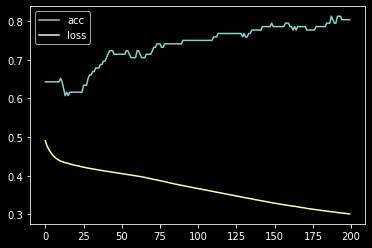

In [314]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['loss'])
plt.legend(['acc', 'loss'], loc='upper left')
plt.show()

In [324]:
predictions2 = nn_pmodel.predict(nn_X_test.to_numpy())

In [325]:
predictions2

array([[0.6655053 , 0.3344947 ],
       [0.19156264, 0.80843735],
       [0.58113706, 0.41886294],
       [0.6826844 , 0.3173155 ],
       [0.68953145, 0.3104685 ],
       [0.5909473 , 0.40905273],
       [0.749221  , 0.25077897],
       [0.39088646, 0.6091135 ],
       [0.9684249 , 0.0315751 ],
       [0.23955514, 0.7604449 ],
       [0.3851693 , 0.61483073],
       [0.5572889 , 0.44271109],
       [0.80998945, 0.19001055]], dtype=float32)

In [323]:
nn_pmodel.evaluate(nn_X_test.to_numpy(), y_test.to_numpy())

13/13 [==============================] - 0s 1ms/sample - loss: 0.7189 - accuracy: 0.6923


[0.7188781499862671, 0.6923077]

In [ ]:
nn_y_test = y_test.to_numpy()
nn_y_test = np.stack([1- nn_y_test, nn_y_test], -1)
nn_pmodel.evaluate(nn_X_test.to_numpy(), nn_y_test.to_numpy())

In [326]:
print(sklearn.metrics.classification_report(y_test.to_numpy(), np.argmax(predictions2, axis=1)))

              precision    recall  f1-score   support

         0.0       0.78      1.00      0.88         7
         1.0       1.00      0.67      0.80         6

    accuracy                           0.85        13
   macro avg       0.89      0.83      0.84        13
weighted avg       0.88      0.85      0.84        13



# Repeated Runs

In [130]:
def runLogRegEval(times):
    hyper_params = {
        'penalty': ['l1', 'l2']
        ,'C': np.logspace(-5, 5, 10)
        ,'solver': ['liblinear','saga']
    }
    models = []
    confusion_matrices = []
    results = []
    for i in range(times):
        labeled_df, unlabeled_df, X_cols, y_col = util.makeDataset(mnm_feature_vec, nomod_mod_label_df)
        X_train, X_test, y_train, y_test = train_test_split(labeled_df[X_cols], 
                                                            labeled_df[y_col], 
                                                            test_size=TEST_SIZE, 
                                                            random_state=RANDOM_STATE_SEED + i)

        grid_search = GridSearchCV(
            estimator = LogisticRegression(max_iter=LOGISTIC_REGRESSION_ITER, random_state=RANDOM_STATE_SEED, class_weight='balanced')
            ,param_grid = hyper_params
            ,scoring = None
            ,n_jobs = 1
            ,cv = 5
            ,verbose = 0
            ,return_train_score = False
        )

        best_model = grid_search.fit(X_train, y_train)
        
        best_params = dict()

        for k in hyper_params.keys():
            best_params[k] = best_model.best_estimator_.get_params()[k]
        
        predictions = best_model.predict(X_test)
        confusion_matrices.append(metrics.confusion_matrix(y_test, predictions))
        result = metrics.classification_report(y_test, predictions, output_dict=True)
        result["best_params"] = best_params
        
        models.append(best_model)
        results.append(result)
    return models, results, confusion_matrices


In [131]:
lr_models, lr_results, lr_confusion_matrices = runLogRegEval(20)

C:\Users\VHAHOUYuM\AppData\Local\Continuum\anaconda3\envs\ahrq-tf\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\Users\VHAHOUYuM\AppData\Local\Continuum\anaconda3\envs\ahrq-tf\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\Users\VHAHOUYuM\AppData\Local\Continuum\anaconda3\envs\ahrq-tf\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are un

In [76]:
AUC = tf.keras.metrics.AUC()

In [108]:
def trainNN(X_train, y_train, unlabeled_df, epochs=200):
    model = tf.keras.Sequential([
        tf.keras.layers.Input(shape=(len(X_train.columns),)),
        tf.keras.layers.Dense(10, activation="relu"),
        tf.keras.layers.Dense(4, activation="relu"),
        tf.keras.layers.Dense(1, activation="sigmoid"),
    ])
    model.compile(optimizer="adam",
                loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
                metrics=['accuracy', AUC])
    history = model.fit(X_train.to_numpy(dtype="float32"), y_train.to_numpy(dtype="float32"), epochs=epochs, verbose=0)
    
    print(model.evaluate(X_train.to_numpy(dtype="float32"), y_train.to_numpy(dtype="float32")))
    
    plt.plot(history.history['auc'])
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['loss'])
    plt.legend(['auc', 'acc', 'loss'], loc='upper left')
    plt.show()
    
    return model

def evaluateNN(model, X_test, y_test):
    model.evaluate(X_test.to_numpy(dtype="float32"), y_test.to_numpy(dtype="float32"))
    prediction = model.predict(X_test.to_numpy(dtype="float32"))
    return sklearn.metrics.classification_report(y_test.to_numpy(), (prediction > 0.5).astype(int), output_dict=True)

In [109]:
def trainPNN(X_train, y_train, unlabeled_df, epochs=200):
    pX, py, pw = pseudo_label.pseudo_label_dataset(pseudo_labeler, X_train, y_train, unlabeled_df)
    n = int(pX.shape[0]/2)
    X = pX.iloc[:n, :].to_numpy(dtype="float32")
    y = pw[:n].astype("float32")
    y = np.stack([1- y, y], -1)
    pmodel = tf.keras.Sequential([
        tf.keras.layers.Input(shape=(len(pX.columns),)),
        tf.keras.layers.Dense(10, activation="relu"),
        tf.keras.layers.Dense(4, activation="relu"),
        tf.keras.layers.Dense(2, activation="softmax"),
    ])
    pmodel.compile(optimizer="adam", loss=tf.keras.losses.KLDivergence(), metrics=["accuracy"])
    history = pmodel.fit(X, y, epochs=epochs, verbose=0)
    
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['loss'])
    plt.legend(['acc', 'loss'], loc='upper left')
    plt.show()
    
    return pmodel

def evaluatePNN(model, X_test, y_test):
    nn_y_test = y_test.to_numpy(dtype="float32")
    nn_y_test = np.stack([1- nn_y_test, nn_y_test], -1)
    model.evaluate(X_test.to_numpy(dtype="float32"), nn_y_test)
    prediction = model.predict(X_test.to_numpy(dtype="float32"))
    return sklearn.metrics.classification_report(y_test.to_numpy(), np.argmax(prediction, axis=1), output_dict=True)

In [102]:
def runNNEval(times, train_func, eval_func):
    models = []
    results = []
    for i in range(times):
        labeled_df, unlabeled_df, X_cols, y_col = util.makeDataset(mnm_feature_vec, nomod_mod_label_df)
        X_train, X_test, y_train, y_test = train_test_split(labeled_df[X_cols], 
                                                            labeled_df[y_col], 
                                                            test_size=TEST_SIZE, 
                                                            random_state=RANDOM_STATE_SEED + i)
        model = train_func(X_train, y_train, unlabeled_df[X_cols])
        models.append(model)
        results.append(eval_func(model, X_test, y_test))
    return models, results

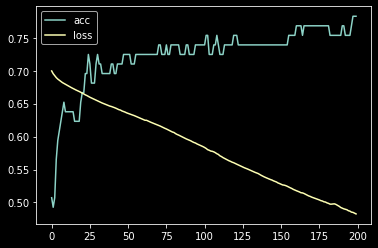

13/13 [==============================] - 0s 20ms/sample - loss: 0.3883 - accuracy: 0.9231


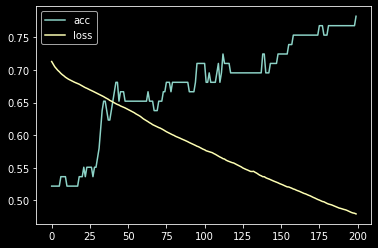

13/13 [==============================] - 0s 23ms/sample - loss: 0.8201 - accuracy: 0.5385


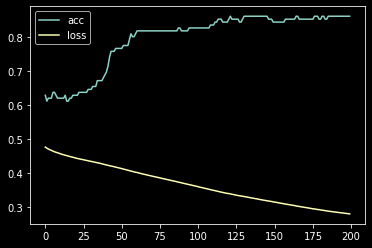

13/13 [==============================] - 0s 19ms/sample - loss: 0.6348 - accuracy: 0.6154


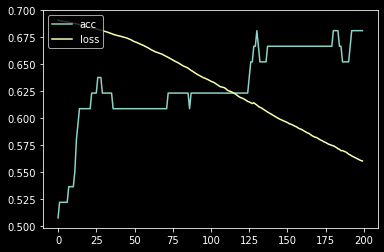

13/13 [==============================] - 0s 23ms/sample - loss: 0.8916 - accuracy: 0.3846


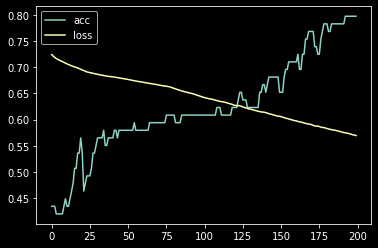

13/13 [==============================] - 0s 23ms/sample - loss: 0.7654 - accuracy: 0.6154


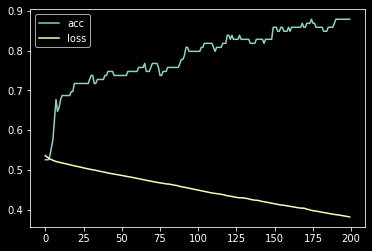

13/13 [==============================] - 0s 24ms/sample - loss: 0.7056 - accuracy: 0.5385


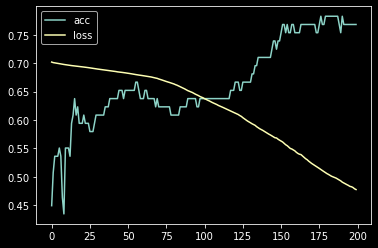

13/13 [==============================] - 0s 19ms/sample - loss: 0.6214 - accuracy: 0.5385


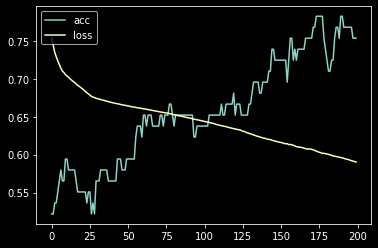

13/13 [==============================] - 0s 33ms/sample - loss: 0.7232 - accuracy: 0.7692


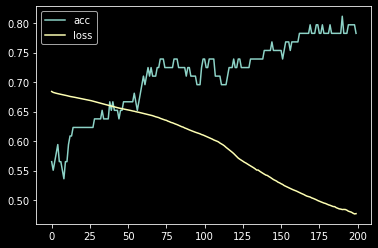

13/13 [==============================] - 0s 21ms/sample - loss: 0.8011 - accuracy: 0.5385


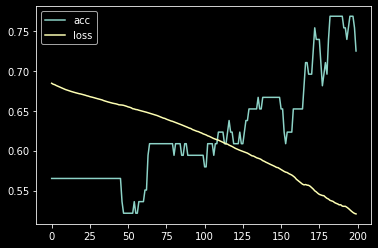

13/13 [==============================] - 0s 26ms/sample - loss: 0.6081 - accuracy: 0.6923


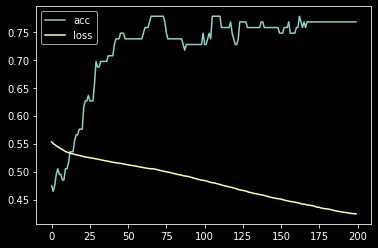

13/13 [==============================] - 0s 21ms/sample - loss: 0.7982 - accuracy: 0.3846


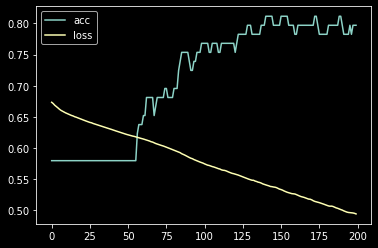

13/13 [==============================] - 0s 27ms/sample - loss: 0.7451 - accuracy: 0.5385


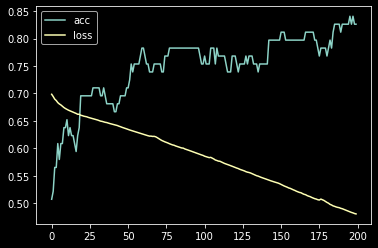

13/13 [==============================] - 0s 23ms/sample - loss: 0.8684 - accuracy: 0.5385


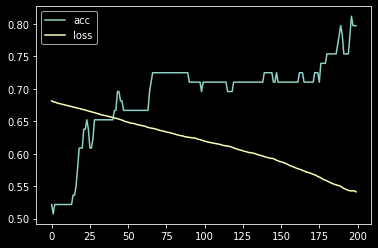

13/13 [==============================] - 0s 21ms/sample - loss: 0.7943 - accuracy: 0.4615


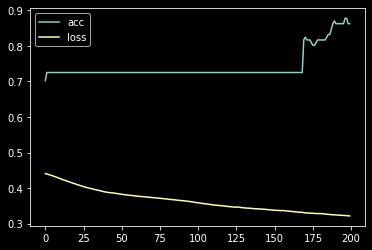

13/13 [==============================] - 0s 26ms/sample - loss: 0.5853 - accuracy: 0.7692


C:\Users\VHAHOUYuM\AppData\Local\Continuum\anaconda3\envs\ahrq-tf\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


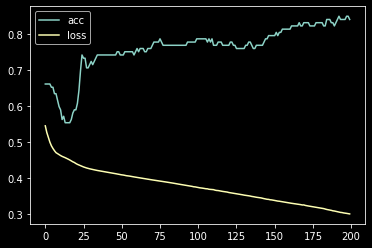

13/13 [==============================] - 0s 22ms/sample - loss: 0.9255 - accuracy: 0.3846


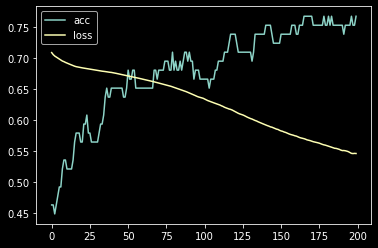

13/13 [==============================] - 0s 22ms/sample - loss: 0.7250 - accuracy: 0.4615


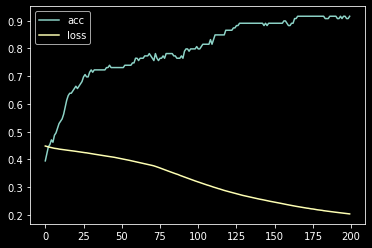

13/13 [==============================] - 0s 20ms/sample - loss: 0.8184 - accuracy: 0.6154


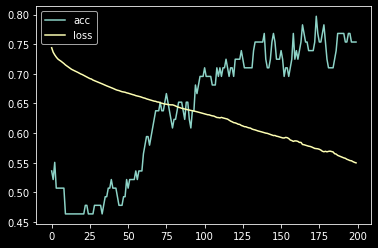

13/13 [==============================] - 0s 26ms/sample - loss: 0.5633 - accuracy: 0.6923


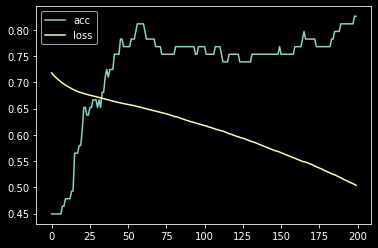

13/13 [==============================] - 0s 21ms/sample - loss: 0.7428 - accuracy: 0.4615


In [110]:
nn_models, nn_results = runNNEval(20, trainPNN, evaluatePNN)

69/69 [==============================] - 1s 12ms/sample - loss: 0.6106 - accuracy: 0.7101 - auc: 0.8349
[0.6106197039286295, 0.71014494, 0.8348818]


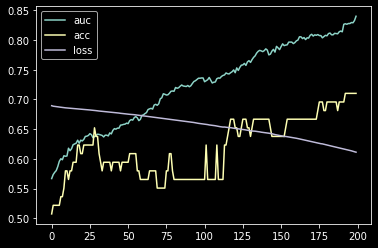

69/69 [==============================] - 1s 13ms/sample - loss: 0.4602 - accuracy: 0.8116 - auc: 0.8756
[0.4602101898711661, 0.8115942, 0.87563026]


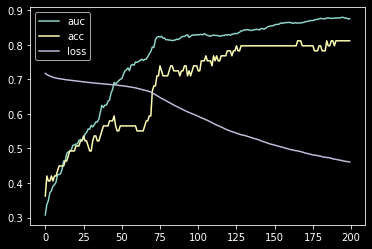

69/69 [==============================] - 1s 13ms/sample - loss: 0.4765 - accuracy: 0.8261 - auc: 0.8949
[0.4764531945836717, 0.82608694, 0.89487183]


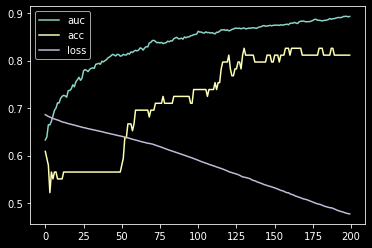

69/69 [==============================] - 1s 13ms/sample - loss: 0.5942 - accuracy: 0.6957 - auc: 0.8279
[0.5941712061564127, 0.6956522, 0.82786196]


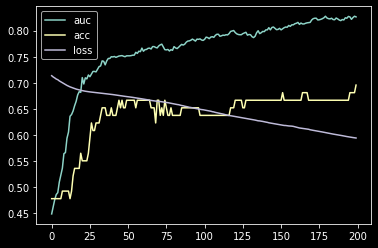

69/69 [==============================] - 1s 13ms/sample - loss: 0.5829 - accuracy: 0.7101 - auc: 0.8107
[0.5828921756018763, 0.71014494, 0.8106837]


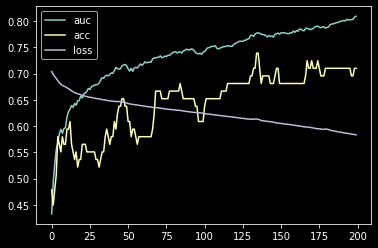

69/69 [==============================] - 1s 14ms/sample - loss: 0.5025 - accuracy: 0.7826 - auc: 0.8643
[0.502464595048324, 0.7826087, 0.8642857]


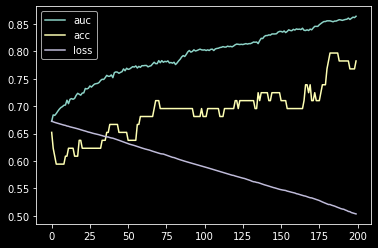

69/69 [==============================] - 1s 12ms/sample - loss: 0.5972 - accuracy: 0.7246 - auc: 0.8409
[0.5971997846727786, 0.7246377, 0.8409091]


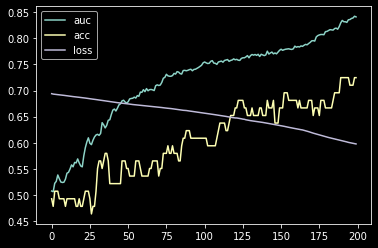

69/69 [==============================] - 1s 12ms/sample - loss: 0.6368 - accuracy: 0.6232 - auc: 0.7807
[0.6368038628412329, 0.6231884, 0.7807239]


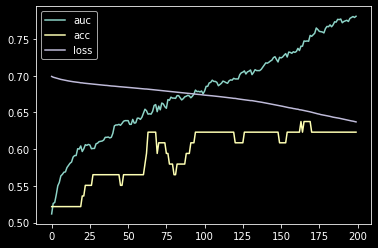

69/69 [==============================] - 1s 11ms/sample - loss: 0.5561 - accuracy: 0.7826 - auc: 0.8778
[0.5561103134051614, 0.7826087, 0.8777589]


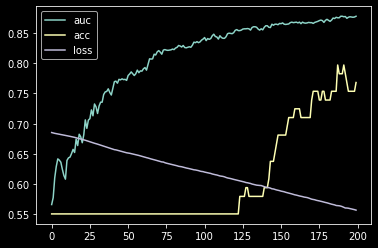

69/69 [==============================] - 1s 13ms/sample - loss: 0.6294 - accuracy: 0.5942 - auc: 0.7521
[0.6294238688289255, 0.5942029, 0.75213677]


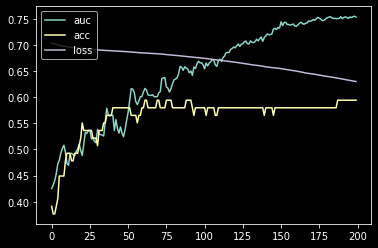

69/69 [==============================] - 1s 11ms/sample - loss: 0.5707 - accuracy: 0.7391 - auc: 0.8666
[0.5706674974897633, 0.73913044, 0.8665825]


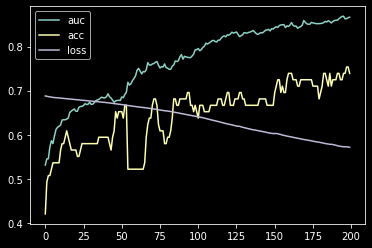

69/69 [==============================] - 1s 11ms/sample - loss: 0.5102 - accuracy: 0.8261 - auc: 0.8491
[0.5101981020492056, 0.82608694, 0.849138]


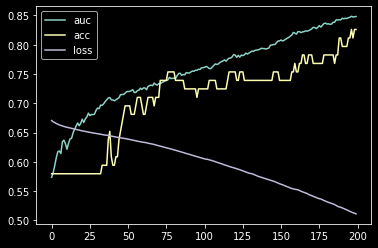

69/69 [==============================] - 1s 11ms/sample - loss: 0.5443 - accuracy: 0.7246 - auc: 0.8274
[0.5443372562311698, 0.7246377, 0.8274411]


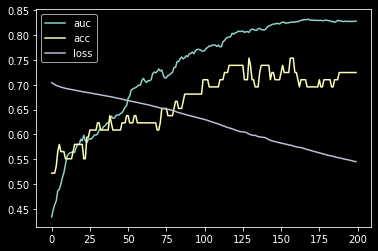

69/69 [==============================] - 1s 13ms/sample - loss: 0.5348 - accuracy: 0.7391 - auc: 0.8986
[0.5348347650058027, 0.73913044, 0.898569]


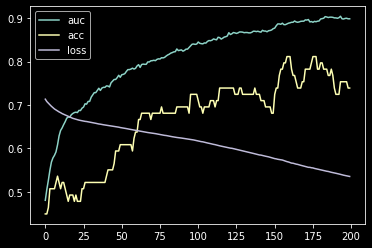

69/69 [==============================] - 1s 11ms/sample - loss: 0.4549 - accuracy: 0.7971 - auc: 0.8685
[0.45486534937568335, 0.79710144, 0.86846685]


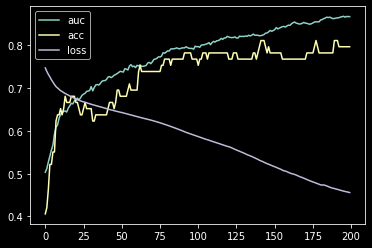

69/69 [==============================] - 1s 11ms/sample - loss: 0.5439 - accuracy: 0.7536 - auc: 0.8141
[0.5439270562019901, 0.7536232, 0.81410253]


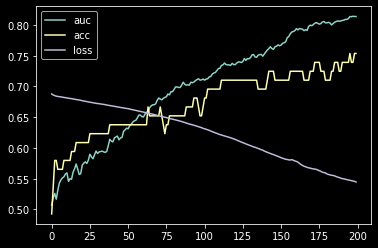

69/69 [==============================] - 1s 15ms/sample - loss: 0.5355 - accuracy: 0.7971 - auc: 0.8300
[0.5355459019757699, 0.79710144, 0.82996637]


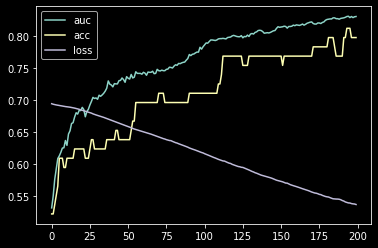

69/69 [==============================] - 1s 11ms/sample - loss: 0.6137 - accuracy: 0.6957 - auc: 0.8034
[0.6137449758640234, 0.6956522, 0.80336136]


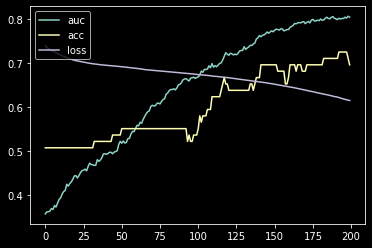

69/69 [==============================] - 1s 11ms/sample - loss: 0.5801 - accuracy: 0.7101 - auc: 0.8151
[0.5801103728404944, 0.71014494, 0.81512606]


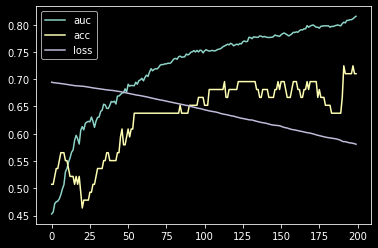

69/69 [==============================] - 1s 12ms/sample - loss: 0.6658 - accuracy: 0.6087 - auc: 0.5632
[0.6658498696658922, 0.6086956, 0.5632428]


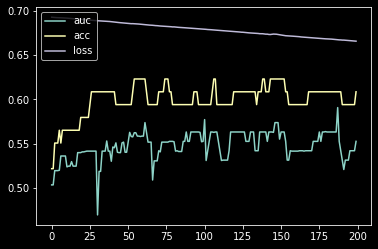

13/13 [==============================] - 0s 1ms/sample - loss: 0.7171 - accuracy: 0.3846 - auc: 0.4167


In [111]:
nn_pmodels, nn_presults = runNNEval(20, trainNN, evaluateNN)

In [112]:
nn_results

[{'0.0': {'precision': 0.875,
   'recall': 1.0,
   'f1-score': 0.9333333333333333,
   'support': 7},
  '1.0': {'precision': 1.0,
   'recall': 0.8333333333333334,
   'f1-score': 0.9090909090909091,
   'support': 6},
  'accuracy': 0.9230769230769231,
  'macro avg': {'precision': 0.9375,
   'recall': 0.9166666666666667,
   'f1-score': 0.9212121212121211,
   'support': 13},
  'weighted avg': {'precision': 0.9326923076923077,
   'recall': 0.9230769230769231,
   'f1-score': 0.9221445221445221,
   'support': 13}},
 {'0.0': {'precision': 0.6666666666666666,
   'recall': 0.6666666666666666,
   'f1-score': 0.6666666666666666,
   'support': 9},
  '1.0': {'precision': 0.25, 'recall': 0.25, 'f1-score': 0.25, 'support': 4},
  'accuracy': 0.5384615384615384,
  'macro avg': {'precision': 0.4583333333333333,
   'recall': 0.4583333333333333,
   'f1-score': 0.4583333333333333,
   'support': 13},
  'weighted avg': {'precision': 0.5384615384615384,
   'recall': 0.5384615384615384,
   'f1-score': 0.53846153

In [119]:
import copy
import json
def aggregateListDict(l):
    agg_d = dict()
    for k in l[0].keys():
        agg_d[k] = []
        
    for d in l:
        for k, v in d.items():
            agg_d[k].append(v)
    
    for k, v in agg_d.items():
        if isinstance(v[0], dict):
            agg_d[k] = aggregateListDict(v)
    return agg_d

def mapDictList(d, f):
    d = copy.deepcopy(d)
    for k, v in d.items():
        if isinstance(v, dict):
            d[k] = mapDictList(v, f)
        else:
            d[k] = f(v)
    return d

In [132]:
lr_results_agg = aggregateListDict(lr_results)
lr_results_agg.pop("best_params")
print("(Averages, Variances):")
print(json.dumps(mapDictList(lr_results_agg, lambda x: (np.mean(np.array(x)), np.var(np.array(x)))), indent=4))

(Averages, Variances):
{
    "0.0": {
        "precision": [
            0.5731020368520368,
            0.03133579004513435
        ],
        "recall": [
            0.8109722222222222,
            0.033402372685185186
        ],
        "f1-score": [
            0.64162224471435,
            0.016222155029005102
        ],
        "support": [
            6.95,
            3.5475000000000003
        ]
    },
    "1.0": {
        "precision": [
            0.4091666666666667,
            0.13927339852607706
        ],
        "recall": [
            0.28428571428571425,
            0.0742424319727891
        ],
        "f1-score": [
            0.3048301698301698,
            0.06615814369058626
        ],
        "support": [
            6.05,
            3.5475000000000003
        ]
    },
    "accuracy": [
        0.5461538461538462,
        0.019467455621301775
    ],
    "macro avg": {
        "precision": [
            0.4911343517593518,
            0.048466138914457134
      

In [129]:
nn_results_agg = aggregateListDict(nn_results)
print("(Averages, Variances):")
print(json.dumps(mapDictList(nn_results_agg, lambda x: (np.mean(np.array(x)), np.var(np.array(x)))), indent=4))

(Averages, Variances):
{
    "0.0": {
        "precision": [
            0.5439592352092353,
            0.06115641202207085
        ],
        "recall": [
            0.5518055555555554,
            0.08299635416666666
        ],
        "f1-score": [
            0.5298946525610612,
            0.061353492364072074
        ],
        "support": [
            6.95,
            3.5475000000000003
        ]
    },
    "1.0": {
        "precision": [
            0.5083821733821734,
            0.07095217838580312
        ],
        "recall": [
            0.5281150793650793,
            0.07453178185626103
        ],
        "f1-score": [
            0.49664356778487206,
            0.05451047382798463
        ],
        "support": [
            6.05,
            3.5475000000000003
        ]
    },
    "accuracy": [
        0.573076923076923,
        0.019215976331360952
    ],
    "macro avg": {
        "precision": [
            0.5261707042957042,
            0.029491505097427168
     

In [128]:
nn_presults_agg = aggregateListDict(nn_presults)
print("(Averages, Variances):")
print(json.dumps(mapDictList(nn_presults_agg, lambda x: (np.mean(np.array(x)), np.var(np.array(x)))), indent=4))

(Averages, Variances):
{
    "0.0": {
        "precision": [
            0.5848160173160173,
            0.03318974543674219
        ],
        "recall": [
            0.7073611111111111,
            0.04516919367283951
        ],
        "f1-score": [
            0.6002259939063344,
            0.014817802256762758
        ],
        "support": [
            6.95,
            3.5475000000000003
        ]
    },
    "1.0": {
        "precision": [
            0.5058730158730158,
            0.117732955404384
        ],
        "recall": [
            0.38922619047619045,
            0.07360324192176872
        ],
        "f1-score": [
            0.3872226466344114,
            0.052593576108489457
        ],
        "support": [
            6.05,
            3.5475000000000003
        ]
    },
    "accuracy": [
        0.5307692307692308,
        0.019467455621301775
    ],
    "macro avg": {
        "precision": [
            0.5453445165945164,
            0.038196799892477644
     